In [0]:
#import des datas
import numpy as np
import pandas as pd
import os
os.chdir(r"D:\Data Machine learning")
df = pd.read_excel(io="Online Retail.xlsx")
print(df.shape)

(541909, 8)


In [0]:
#aperçu du dataframe :
nbligne = df.shape[0]
df.drop_duplicates(inplace=True)
nbligne_sansdoublons = df.shape[0]
nb_doublons = nbligne-nbligne_sansdoublons
taux_doublons = round(((nbligne-nbligne_sansdoublons)/nbligne)*100,2)
print(nb_doublons," ont été supprimées soit ", taux_doublons,"%")
df.head(10)

5268  ont été supprimées soit  0.97 %


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [0]:
#Cleaning : 
#Suppression des lignes sans CustomerID:
nbligne2 = df.shape[0]
df.dropna(subset =["CustomerID"],inplace=True)
nbligne_noID = nbligne2 - df.shape[0]
taux_noID = round((nbligne_noID / nbligne2)*100,2)
print(nbligne_noID, "lignes sans ID clients ont été supprimées, soit ", taux_noID, "%")
#Création de la variable prix : 
df['Price'] = df.Quantity * df.UnitPrice

135037 lignes sans ID clients ont été supprimées, soit  25.16 %


In [0]:
#Création dataframe client : 
df_client = pd.DataFrame({}, index = df["CustomerID"])

In [0]:
#Nombre de discount : 
df_discount = df[df['StockCode']=='D']
df_client["totalDiscount"] = df_discount.groupby(['CustomerID'])['InvoiceNo'].nunique()

#Nombre de Cancelled :
df_cancelled = df[df['StockCode']!='D']
df_cancelled = df_cancelled[df_cancelled.InvoiceNo.str.contains('C')==True]
df_client["totalCancelled"] = df_cancelled.groupby(['CustomerID'])['InvoiceNo'].nunique()
#remplace NaN par 0
df_client["totalCancelled"] = df_client["totalCancelled"].fillna(value = 0)
df_client["totalDiscount"] = df_client["totalDiscount"].fillna(value = 0)
#Booleen (pour pas overfit sur ces variables)
df_client.totalCancelled[df_client["totalCancelled"]>0] = 1
df_client.totalDiscount[df_client["totalDiscount"]>0] = 1

In [0]:
#Suppression des lignes avec quantité négative ( remise ou annulation )
df = df[(df['Quantity']>0)]

In [0]:
#Création des features: 
df_client["minUnitPrice"] = df.groupby("CustomerID")["UnitPrice"].min() #Prix unitaire minimum 
df_client["maxUnitPrice"] = df.groupby("CustomerID")["UnitPrice"].max() #Prix unitaire max 
df_client["meanUnitPrice"] = df.groupby("CustomerID")["UnitPrice"].mean() #Prix unitaire moyen 
df_client["SDevUnitPrice"] = df.groupby("CustomerID")["UnitPrice"].std() #Standard Deviation Prix unitaire
df_client["minNbArticle"] = df.groupby(['CustomerID'])["Quantity"].min() #Nb min d'article par commande
df_client["maxNbArticle"] = df.groupby(['CustomerID'])["Quantity"].max() #Nb max d'article par commande
df_client["totalNbArticle"] = df.groupby(['CustomerID'])["Quantity"].sum() #Nb total d'article
df_client["totalAmount"] = df.groupby(['CustomerID'])["Price"].sum() #montant total des achats 
df_client["totalInvoice"] = df.groupby(['CustomerID'])['InvoiceNo'].nunique() #Nb total de commandes
df_client["dateLastInvoice"] = df.groupby(['CustomerID'])['InvoiceDate'].max() #Date de commandes la plus récente 
df_client["dateFirstInvoice"] = df.groupby(['CustomerID'])['InvoiceDate'].min() #Date de commandes la plus ancienne
df_client["meanPriceInvoice"] = df_client.totalAmount/df_client.totalInvoice #Montant moyen des commandes 
df_client["SdevPrice"] = df.groupby(['CustomerID'])["Price"].std() #Standard Deviation Prix par commandes
df_client["SDevUnitPrice"].fillna(0, inplace=True)
df_client["SdevPrice"].fillna(0, inplace=True)

In [0]:
from datetime import datetime,timedelta
#date :
dateRef  = max(df['InvoiceDate']) #date de référence pour Récence: date de la plus récente commande
dateMin  = min(df['InvoiceDate']) #date de début de la période d'observation : date de la plus ancienne commande

print("Données entre le ", dateMin," et le ",dateRef)

#Fonction transforme le type jour en int:
def time_to_days(vect):
    result = []
    for e in vect:
        result.append(e.days)
    return result

#variable first et last invoice en nb de jours (partant de date ref):
df_client["daysLastInvoice"] = dateRef - df_client["dateLastInvoice"]
df_client["daysFirstInvoice"] = dateRef - df_client["dateFirstInvoice"]
df_client["daysLastInvoice"] = time_to_days(df_client["daysLastInvoice"])
df_client["daysFirstInvoice"]  = time_to_days(df_client["daysFirstInvoice"])

Données entre le  2010-12-01 08:26:00  et le  2011-12-09 12:50:00


In [0]:
#Suppression doublons :
df_client = df_client.reset_index().drop_duplicates(subset='CustomerID', keep='last').set_index('CustomerID')
#Apperçu : 
df_client.head(5)

,totalDiscount,totalCancelled,minUnitPrice,maxUnitPrice,meanUnitPrice,SDevUnitPrice,minNbArticle,maxNbArticle,totalNbArticle,totalAmount,totalInvoice,dateLastInvoice,dateFirstInvoice,meanPriceInvoice,SdevPrice,daysLastInvoice,daysFirstInvoice
CustomerID,,,,,,,,,,,,,,,,,
18074.0,0.0,0.0,0.65,12.75,4.780769,3.698059,2.0,48.0,190.0,489.60,1.0,2010-12-01 09:53:00,2010-12-01 09:53:00,489.60,28.254374,373.0,373.0
13747.0,0.0,0.0,9.95,9.95,9.950000,0.000000,8.0,8.0,8.0,79.60,1.0,2010-12-01 10:37:00,2010-12-01 10:37:00,79.60,0.000000,373.0,373.0
12791.0,0.0,0.0,1.85,15.00,8.425000,9.298454,1.0,96.0,97.0,192.60,1.0,2010-12-01 11:27:00,2010-12-01 11:27:00,192.60,114.975563,373.0,373.0
17908.0,0.0,0.0,0.12,7.95,2.662222,2.028171,1.0,28.0,169.0,232.03,1.0,2010-12-01 11:45:00,2010-12-01 11:45:00,232.03,3.585861,373.0,373.0
16583.0,0.0,0.0,1.25,4.95,2.564286,1.194125,3.0,12.0,111.0,233.45,1.0,2010-12-01 12:03:00,2010-12-01 12:03:00,233.45,1.976472,373.0,373.0


In [0]:
#Supression des clients sans commande (totalInvoice = NaN):
df_client = df_client[(df_client['totalInvoice']>0)]

In [0]:
df_client.shape

(4339, 17)

In [0]:
import matplotlib.pyplot as plt
#Graphique nombre de commandes par mois : 
x = df.groupby('InvoiceDate')['InvoiceNo'].nunique()
x_rspl = x.resample('1M').sum()
x_rspl[12]=x_rspl[12]*3 #Interpolation (10 jours de data pour ce mois)
fig, ax1 = plt.subplots()
ax1.plot(x_rspl.index, x_rspl.values, 'g-',marker='+',markersize=10,markeredgecolor='black')
ax1.set_xlabel('Mois',color='g')
ax1.set_ylabel('Nb Invoice', color='g')
plt.title('Nombre de commandes au cours de l\'année')
plt.show()

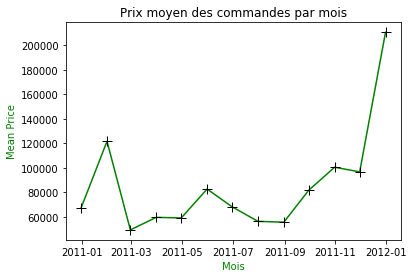

In [0]:
#Graphique nombre de commandes par mois : 
y = df.groupby('InvoiceDate')['Price'].mean()
y_rspl = y.resample('1M').sum()
fig, ax1 = plt.subplots()
ax1.plot(y_rspl.index, y_rspl.values, 'g-',marker='+',markersize=10,markeredgecolor='black')
ax1.set_xlabel('Mois',color='g')
ax1.set_ylabel('Mean Price', color='g')
plt.title('Prix moyen des commandes par mois')
plt.show()

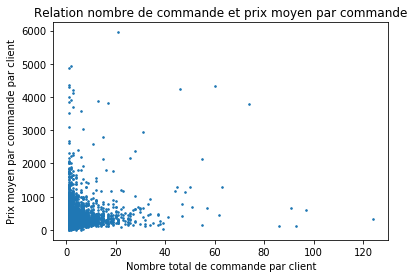

In [0]:
#Graphique prix moyen vs nb facture : 
filtre1 =df_client[df_client.meanPriceInvoice<6000]
filtre2 =filtre1[filtre1.totalInvoice<200]
plt.scatter(filtre2['totalInvoice'],filtre2['meanPriceInvoice'],s=10,marker = ".")
plt.ylabel("Prix moyen par commande par client")
plt.xlabel("Nombre total de commande par client")
plt.title("Relation nombre de commande et prix moyen par commande")
plt.show()

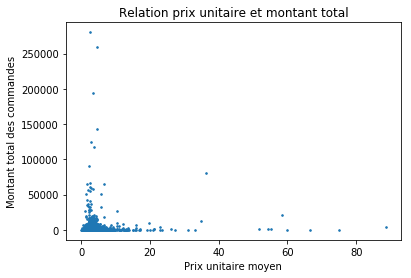

In [0]:
#Graphique prix moyen vs nb facture : 
filtre3 =df_client[df_client.meanPriceInvoice<6000]
filtre4 =filtre3[filtre3.meanUnitPrice<100]
plt.scatter(filtre4['meanUnitPrice'],filtre4['totalAmount'],s=10,marker = ".")
plt.xlabel("Prix unitaire moyen")
plt.ylabel("Montant total des commandes")
plt.title("Relation prix unitaire et montant total")
plt.show()

In [0]:
#dataframe pour segmentation :
df_seg = df_client[['totalCancelled','totalDiscount','meanUnitPrice','totalNbArticle','totalAmount',
                    'totalInvoice','meanPriceInvoice','daysLastInvoice',
                    'daysFirstInvoice','SDevUnitPrice','SdevPrice',                   
                    ]]

#Normalisation des données:
from sklearn import preprocessing
X = df_seg.as_matrix()
scaler = preprocessing.StandardScaler().fit(X)
X_norm = scaler.transform(X)

In [0]:
df_seg.head(5)

,totalCancelled,totalDiscount,meanUnitPrice,totalNbArticle,totalAmount,totalInvoice,meanPriceInvoice,daysLastInvoice,daysFirstInvoice,SDevUnitPrice,SdevPrice
CustomerID,,,,,,,,,,,
18074.0,0.0,0.0,4.780769,190.0,489.60,1.0,489.60,373.0,373.0,3.698059,28.254374
13747.0,0.0,0.0,9.950000,8.0,79.60,1.0,79.60,373.0,373.0,0.000000,0.000000
12791.0,0.0,0.0,8.425000,97.0,192.60,1.0,192.60,373.0,373.0,9.298454,114.975563
17908.0,0.0,0.0,2.662222,169.0,232.03,1.0,232.03,373.0,373.0,2.028171,3.585861
16583.0,0.0,0.0,2.564286,111.0,233.45,1.0,233.45,373.0,373.0,1.194125,1.976472


In [0]:
#DBSCAN segmentation :
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

epsilon = np.arange(0.3,0.5,0.05)
min_sample = np.arange(10,25,1)
for esp in epsilon:
    for min_spl in min_sample:
        db = DBSCAN(eps=esp, min_samples=min_spl).fit(X_norm)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        # Nombre de cluster :
        liste_lab = list(labels)
        compte = {k: liste_lab.count(k) for k in set(liste_lab)}
        if (compte[-1]<1000 and len(compte)>4 and len(compte)<10):
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            print('Estimated number of clusters: %d' % n_clusters_)
            print("esp :",esp," min_samples :",min_spl)
            print(compte)
        

Estimated number of clusters: 6
esp : 0.3  min_samples : 10
{0: 2520, 1: 19, 2: 134, 3: 11, 4: 868, 5: 9, -1: 778}
Estimated number of clusters: 6
esp : 0.3  min_samples : 11
{0: 2501, 1: 19, 2: 131, 3: 11, 4: 852, 5: 9, -1: 816}
Estimated number of clusters: 5
esp : 0.3  min_samples : 12
{0: 2491, 1: 19, 2: 115, 3: 16, 4: 841, -1: 857}
Estimated number of clusters: 6
esp : 0.3  min_samples : 13
{0: 2454, 1: 18, 2: 115, 3: 32, 4: 14, 5: 832, -1: 874}
Estimated number of clusters: 6
esp : 0.3  min_samples : 14
{0: 2429, 1: 18, 2: 113, 3: 39, 4: 13, 5: 824, -1: 903}
Estimated number of clusters: 5
esp : 0.3  min_samples : 15
{0: 2427, 1: 18, 2: 113, 3: 32, 4: 822, -1: 927}
Estimated number of clusters: 6
esp : 0.3  min_samples : 16
{0: 2417, 1: 18, 2: 83, 3: 22, 4: 30, 5: 798, -1: 971}
Estimated number of clusters: 4
esp : 0.35  min_samples : 17
{0: 2560, 1: 19, 2: 129, 3: 947, -1: 684}
Estimated number of clusters: 4
esp : 0.35  min_samples : 18
{0: 2557, 1: 18, 2: 115, 3: 925, -1: 724}

In [0]:
#On garde esp = 0.40 et min_samples= 21
db = DBSCAN(eps=0.40, min_samples=21).fit(X_norm)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [0]:
#colonne labels + taille des clusters:
df_seg =df_seg.assign(labels = labels)
df_seg.groupby(['labels']).size()

labels
-1     544
 0    2614
 1     148
 2      21
 3    1012
dtype: int64

In [0]:
#Interprétation des cluster : 
#Aperçu des clusters :
round(df_seg.groupby(['labels']).mean(),2)

,totalCancelled,totalDiscount,meanUnitPrice,totalNbArticle,totalAmount,totalInvoice,meanPriceInvoice,daysLastInvoice,daysFirstInvoice,SDevUnitPrice,SdevPrice
labels,,,,,,,,,,,
-1,0.68,0.04,13.78,5372.33,9391.63,12.44,1137.79,81.72,287.51,15.04,294.86
0,0.00,0.00,3.11,402.61,659.11,2.27,294.92,107.88,194.54,2.68,15.26
1,1.00,0.00,3.44,246.25,420.98,1.38,319.38,224.95,238.57,2.87,12.83
2,1.00,0.00,3.24,364.57,568.01,2.90,212.52,168.29,341.29,2.73,20.75
3,1.00,0.00,3.14,1133.21,1957.54,5.51,365.67,33.43,253.94,3.07,17.01


In [0]:
df_seg['labels'][df_seg['labels']==-1] = 4

C:\Users\adrien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


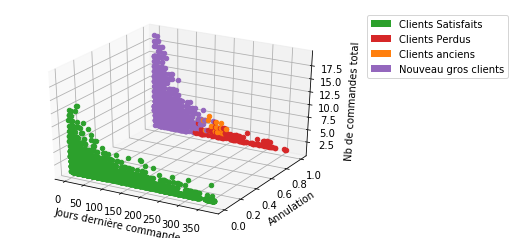

In [0]:
# Visualisation caractéristiques des cluster :
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

df_seg_repr1 = df_seg[df_seg['labels']<4]
color = ['tab:green', 'tab:red','tab:orange', 'tab:purple']
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(len(df_seg_repr1)):
    ax.scatter(df_seg_repr1['daysLastInvoice'].iloc[i], 
               df_seg_repr1['totalCancelled'].iloc[i],
               df_seg_repr1['totalInvoice'].iloc[i],
               c=color[df_seg_repr1['labels'].iloc[i]]) 
ax.set_xlabel("Jours dernière commande")
ax.set_ylabel("Annulation")
ax.set_zlabel("Nb de commandes total")
recs = []
for c in color: 
    recs.append(mpatches.Circle((0,0),fc=c))
classes = ['Clients Satisfaits','Clients Perdus','Clients anciens','Nouveau gros clients']
lgd = plt.legend(recs,classes,bbox_to_anchor=(1.05, 1), loc=2)
plt.savefig("3D-no1.png",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


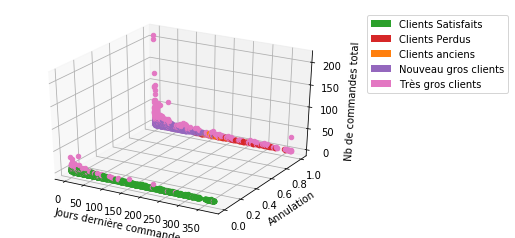

In [0]:
# Visualisation caractéristiques des cluster :
from mpl_toolkits.mplot3d import Axes3D

color = ['tab:green', 'tab:red','tab:orange', 'tab:purple','tab:pink']
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(len(df_seg)):
    ax.scatter(df_seg['daysLastInvoice'].iloc[i], 
               df_seg['totalCancelled'].iloc[i],
               df_seg['totalInvoice'].iloc[i],
               c=color[df_seg['labels'].iloc[i]]) 
ax.set_xlabel("Jours dernière commande")
ax.set_ylabel("Annulation")
ax.set_zlabel("Nb de commandes total")
recs = []
for c in color: 
    recs.append(mpatches.Circle((0,0),fc=c))
classes = ['Clients Satisfaits','Clients Perdus','Clients anciens','Nouveau gros clients','Très gros clients']
lgd = plt.legend(recs,classes,bbox_to_anchor=(1.05, 1), loc=2)
plt.savefig("3D-no2.png",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


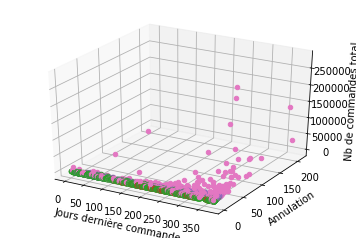

In [0]:
# Visualisation caractéristiques des cluster :
from mpl_toolkits.mplot3d import Axes3D

color = ['tab:green', 'tab:red','tab:orange', 'tab:purple','tab:pink']
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(len(df_seg)):
    ax.scatter(df_seg['daysFirstInvoice'].iloc[i], 
               df_seg['totalInvoice'].iloc[i],
               df_seg['totalAmount'].iloc[i],
               c=color[df_seg['labels'].iloc[i]]) 
ax.set_xlabel("Jours dernière commande")
ax.set_ylabel("Annulation")
ax.set_zlabel("Nb de commandes total")
plt.savefig("3D-no3.png")
plt.show()

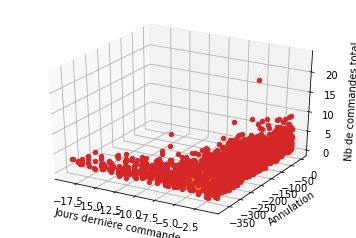

In [0]:
# Visualisation caractéristiques des cluster :
from mpl_toolkits.mplot3d import Axes3D

color = ['tab:green', 'tab:red','tab:orange', 'tab:purple','tab:pink']
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(len(df_seg_repr1)):
    ax.scatter(-df_seg_repr1['totalInvoice'].iloc[i], 
               -df_seg_repr1['daysFirstInvoice'].iloc[i],
               df_seg_repr1['meanUnitPrice'].iloc[i],
               c=color[df_seg_repr1['labels'].iloc[i]]) 
ax.set_xlabel("Jours dernière commande")
ax.set_ylabel("Annulation")
ax.set_zlabel("Nb de commandes total")
plt.savefig("3D-no4.png")
plt.show()

In [0]:
round(df_seg.mean(),2)

totalCancelled         0.36
totalDiscount          0.01
meanUnitPrice          4.47
totalNbArticle      1190.57
totalAmount         2048.22
totalInvoice           4.27
meanPriceInvoice     417.53
daysLastInvoice       91.52
daysFirstInvoice     222.26
SDevUnitPrice          4.33
SdevPrice             50.67
labels                 0.62
dtype: float64

In [0]:
#Export du dataframe avec clusters : 
df_seg.to_csv('data-clients.csv',sep='\t')